In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce

In [80]:
fontsize = 16
lw = 2

In [81]:
path1 = '01_Data/00_Reports/DIANN180/'
path2 = '01_Data/00_Reports/Spec18/'

names = ['indiv', 'mbr', 
         '+1_5', '+5_5', '+10_5', '+100_5',
         '+1_10', '+5_10', '+10_10', '+100_10',
         '+1_20', '+5_20', '+10_20', '+100_20']

dnn_reports = []
spec_reports = []

# for diann
indiv_reports = []
for i in range(7):
    frame = pd.read_csv(path1 + 'r' + str(i+1) + '_report.tsv', sep='\t')
    indiv_reports.append(frame)
    
dnn_reports.append(pd.concat(indiv_reports))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path1 + name + '_report.tsv', sep='\t')
        dnn_reports.append(frame)

# for spectronaut
indiv_reports = []
for i in range(7):
    frame = pd.read_csv(path2 + 'r' + str(i+1) + '_report.tsv', sep='\t')
    indiv_reports.append(frame)
    
spec_reports.append(pd.concat(indiv_reports))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path2 + name + '_report.tsv', sep='\t')
        spec_reports.append(frame) 
        

In [82]:
# for diann
for i, frame in enumerate(dnn_reports):
    organisms = []
    for row in frame['Protein.Names']:
        elements = [i.split('_')[-1] for i in row.split(';')]
        organisms.append(';'.join(elements))
    frame.loc[:,('Organism')] = organisms
    frame = frame[~(frame['Organism'].str.contains('HUMAN') & frame['Organism'].str.contains('ECOLI'))]
    dnn_reports[i] = frame[frame['Run'].str.contains('00perc')]
    
# for spectronaut
ec_anno = pd.read_csv('01_Data/Ecoli_K12_annotation_20230630.tsv', sep='\t')
ec_anno_set = set(ec_anno['Entry'])

for i, frame in enumerate(spec_reports):
    organisms = []
    for row in frame['PG.ProteinGroups']:
        organism = ['ECOLI' if prot in ec_anno_set else 'HUMAN' for prot in row.split(';')]
        organisms.append(';'.join(organism))
    frame.loc[:,('Organism')] = organisms
    frame = frame[~(frame['Organism'].str.contains('HUMAN') & frame['Organism'].str.contains('ECOLI'))]
    spec_reports[i] = frame[frame['R.FileName'].str.contains('00perc')]

In [83]:
dnn_qvalues = ['Q.Value', 'Global.Q.Value', 'Lib.Q.Value', 'PG.Q.Value', 'Global.PG.Q.Value', 'Lib.PG.Q.Value']
spec_qvalues = ['EG.Qvalue', 'PG.Qvalue', 'PG.QValue (Run-Wise)']

dnn_frames = []
spec_frames = []

# for diann
for i, frame in enumerate(dnn_reports):
    frame['ECOLI'] = ['+' if 'ECOLI' in r else '' for r in frame['Organism']]
    frame = frame[['Protein.Group', 'Modified.Sequence'] + dnn_qvalues + ['ECOLI']]
    dnn_frames.append(frame)
    
#     frame.to_csv('01_Data/05_ROC_data/Qvals+Ecoli/DIANN_' + names[i] + '_Qvals+Ecoli.tsv', sep='\t')

# for spectronaut
for i, frame in enumerate(spec_reports):
    frame['ECOLI'] = ['+' if 'ECOLI' in r else '' for r in frame['Organism']]
    frame = frame[['PG.ProteinGroups', 'EG.ModifiedSequence'] + spec_qvalues + ['ECOLI']]
    spec_frames.append(frame)
    
#     frame.to_csv('01_Data/05_ROC_data/Qvals+Ecoli/Spec_' + names[i] + '_Qvals+Ecoli.tsv', sep='\t')

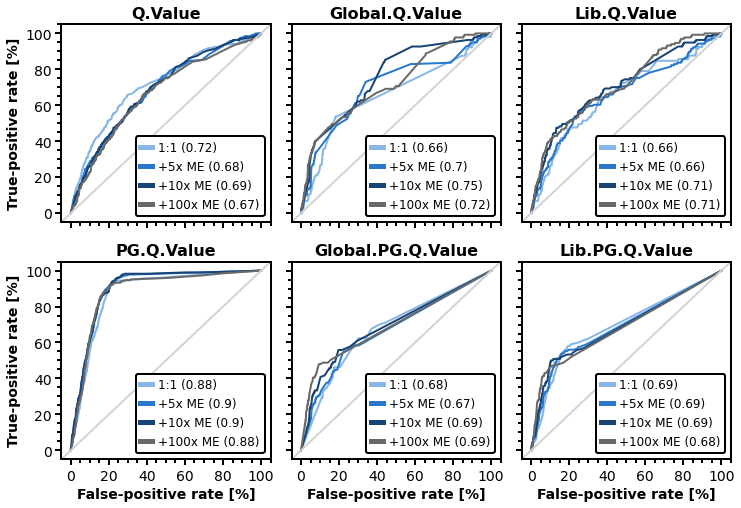

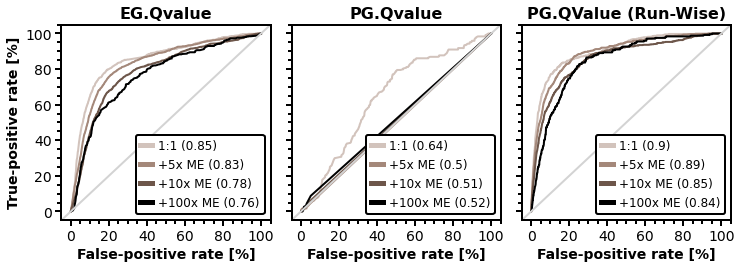

In [84]:
import sklearn.metrics as metrics

labels = ['1:1', '+5x ME', '+10x ME', '+100x ME']
colors = ['#88B6E7', '#2878CC', '#174475', 'dimgrey']
colors2 = ['#D2C3BC', '#A4887A', '#6D564A', 'black']

fig, ax = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axs = fig.axes

handles = [[], [], [], [], [], []]

for i, frame in enumerate(dnn_frames[6:10]):
    
    for j in range(len(dnn_qvalues)):

        data = frame[['Protein.Group', 'Modified.Sequence', dnn_qvalues[j], 'ECOLI']]
        
        if j < 3:
            data = data.drop(columns='Protein.Group').drop_duplicates()
            
        if j >= 3:
            data = data.drop(columns='Modified.Sequence').drop_duplicates()
            
        fpr, tpr, threshold = metrics.roc_curve(y_score=data[dnn_qvalues[j]], y_true=data['ECOLI'], pos_label='+')
        auc = str(round(metrics.auc(fpr, tpr),2))
        
        sns.lineplot(x=fpr*100, y=tpr*100, linewidth=2, color=colors[i], ax=axs[j])
 
        line = mpl.lines.Line2D([], [], color=colors[i], label=labels[i]+' (' + auc + ')', linewidth=5)
        handles[j].append(line)
    
for i in range(len(dnn_qvalues)):
    
    axs[i].set_title(dnn_qvalues[i], fontsize=fontsize, fontweight='bold')

    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(lw)
        
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
    axs[i].tick_params(axis='both', which='minor', length=lw*2, width=lw)    

    axs[i].axline((0,0), slope=1, color='lightgrey', linestyle='solid', linewidth=lw)
    
    axs[i].set_xlabel('False-positive rate [%]', fontsize=fontsize-2, fontweight='bold')
    axs[i].set_ylabel('True-positive rate [%]', fontsize=fontsize-2, fontweight='bold')
    
    axs[i].set_xticks(range(0,120,20), fontsize=fontsize)
    
    legend = axs[i].legend(handles=handles[i], fontsize=fontsize-4, handlelength=1, handleheight=1,
                           handletextpad=0.5, edgecolor='k', framealpha=1, loc=4)
    legend.get_frame().set_linewidth(lw)
    
# plt.savefig('02_Figures/ROCs_Q-Values_DIA-NN.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/ROCs_Q-Values_DIA-NN.pdf', dpi=400, bbox_inches='tight')    

# -------------------------------  
fig, ax = plt.subplots(1, 3, figsize=(12,3.6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axs = fig.axes

handles = [[], [], []]

for i, frame in enumerate(spec_frames[6:10]):
    
    for j in range(len(spec_qvalues)):

        data = frame[['PG.ProteinGroups', 'EG.ModifiedSequence', spec_qvalues[j], 'ECOLI']]
        
        if j == 0:
            data = data.drop(columns='PG.ProteinGroups').drop_duplicates()
            
        if j > 0:
            data = data.drop(columns='EG.ModifiedSequence').drop_duplicates()
            
        fpr, tpr, threshold = metrics.roc_curve(y_score=data[spec_qvalues[j]], y_true=data['ECOLI'], pos_label='+')
        auc = str(round(metrics.auc(fpr, tpr),2))
        
        sns.lineplot(x=fpr*100, y=tpr*100, linewidth=2, color=colors2[i], ax=axs[j])
        
        line = mpl.lines.Line2D([], [], color=colors2[i], label=labels[i]+' (' + auc + ')', linewidth=5)
        handles[j].append(line)
                
for i in range(len(spec_qvalues)):
    
    axs[i].set_title(spec_qvalues[i], fontsize=fontsize, fontweight='bold')

    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(lw)
        
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
    axs[i].tick_params(axis='both', which='minor', length=lw*2, width=lw)    
    
    axs[i].axline((0,0), slope=1, color='lightgrey', linestyle='solid', linewidth=lw)
    
    axs[i].set_xlabel('False-positive rate [%]', fontsize=fontsize-2, fontweight='bold')
    axs[i].set_ylabel('True-positive rate [%]', fontsize=fontsize-2, fontweight='bold')
    
    axs[i].set_xticks(range(0,120,20), fontsize=fontsize)
    
    legend = axs[i].legend(handles=handles[i], fontsize=fontsize-4, handlelength=1, handleheight=1,
                           handletextpad=0.5, edgecolor='k', framealpha=1, loc=4)
    legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/ROCs_Q-Values_Spectronaut.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/ROCs_Q-Values_Spectronaut.pdf', dpi=400, bbox_inches='tight')    
